In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [14]:
def combine_bh(df, data):
    df.rename(columns={"PointID" : "raw PointID"}, inplace=True)
    df["PointID"] = df["raw PointID"].apply(lambda x: x[:13])
    df = df[df[data].notna()].copy()
    df["Index"] = df.apply(lambda x: find_index(geo_df, x.PointID, x.Depth), axis=1)
    return df

def process_df(df, geo_df, data):
    df = combine_bh(df, data)
    df[["σv (kPa)", "σ'v (kPa)"]] = df.apply(lambda x: effective_stress(geo_df, x.PointID, x.Depth, x.Index), axis=1, result_type="expand")
    df["Su/σ'v"] = df["Su"]/df["σ'v (kPa)"]
    return df

def find_index(geo_df, bh, depth):
    try: 
        filtered_df = geo_df[geo_df["PointID"] == bh]
        bottom_depth = filtered_df["Depth"].iloc[-1]
        for index, row in filtered_df.iterrows():
            if depth >= row["Top depth"] and depth < row["Depth"]:
                ind = row["Index"]
            elif depth == bottom_depth:
                ind =  bottom_depth = filtered_df["Index"].iloc[-1]
                break
        return ind
    except Exception as e:
        print("find_index", bh, depth, e)
        return "error"
    
def effective_stress(geo_df, bh, depth, index):
    # Filtered the df by BH
    filtered_df = geo_df[geo_df["PointID"] == bh]
    try: 
        # Extract the values
        cum_BD = filtered_df.loc[filtered_df.Index == index, "Cum BD (kn/m3)"].values[0]
        layer_depth = filtered_df.loc[filtered_df.Index == index, "Top depth"].values[0]
        layer_BD = filtered_df.loc[filtered_df.Index == index, "Mean BD (kn/m3)"].values[0]
        water_depth = 42.5
        total_stress = cum_BD + (depth - layer_depth) * layer_BD + 9.8*water_depth
        pwp = (depth+water_depth)*9.8
        ve = total_stress - pwp
        return total_stress, ve
    except Exception as e:
        print("Ve", bh, depth, index, e)
        return "Error"

def find_parameter(bh, depth, index, df, parameter, **kwargs):
    try:
        filtered_df = df[(df["PointID"] == bh) & (df["Index"] == index)].copy()
        if len(filtered_df) == 0:
            filtered_df = df[(df["PointID"] == bh)]
        filtered_df["delta"] = filtered_df["Depth"].apply(lambda x: abs(x - depth))
        filtered_df = filtered_df.sort_values(by=['delta'])
        filtered_df.reset_index(drop=True, inplace=True)
        value = filtered_df[parameter][0]
        delta = filtered_df["delta"][0]
        delta_index = filtered_df["Index"][0] - index
        if kwargs.get("stats", False) == True:
            return value, delta, delta_index
        else:
            return value
    except Exception as e:
        print(bh, depth, e)
        return "error"

def find_cpt_data(cpt_df, bh, depth, param):
    try:
        df = cpt_df[(cpt_df["PointID"] == bh) & (cpt_df["Depth (m)"] >= depth - 0.05) & (cpt_df["Depth (m)"] <= depth + 0.05)]
        mean = df[param].mean()
    except Exception as e:
        print(bh, e)
        mean = "error"
    return mean

## Import Su from gINT raw data


In [15]:
sample, depth, su, test = [], [], [], []
su_dict = {
    "LPEN" : "LPEN_PPEN",
    "TORV":"TORV_PUSS",
    "UU":"TRIT_CU",
    "CU":"TRET_SHST",
    "DSS":"DSST_FSHS"}

for test_type in su_dict:
    df = pd.read_excel("data/gint export_310724_su.xlsx", test_type)
    if test_type == "CU":
        cu_test_type = df["Test type"].to_list()
    # Add id, su and tests into respective lists
    for i in range(len(df)):
        sample.append(df["PointID"][i])
        depth.append(df["Depth"][i])
        su.append(abs(df[su_dict[test_type]][i]))    # use abs here because some Su from CAUe are negative
        if test_type == "CU":
            test.append(df["Test type"][i])
        else:
            test.append(test_type)

In [19]:
cpt_df

,Unnamed: 0.1,Unnamed: 0,PointID,CPT_hole,Depth (m),qc (MPa),fs (MPa),Inc. NS,Inc EW,u2 (MPa),...,Rf,Qt (kPa),Bq,Ic,Su,OCR Robertson,OCR Mayne,Su/σ'v,Qnc,mCPTu
0,0,0,544WTG23-BH10,CPT10,0.00000,0.003214,0.0,-0.425142,0.372760,0.000597,...,0.0,0.000000,1.006624,0.0,-29.511864,0.0,0.0,-inf,0.0,0.0
1,1,1,544WTG23-BH10,CPT10,0.01000,0.003214,0.0,-1.389042,-0.696828,0.000597,...,0.0,-4635.044658,1.006405,0.0,-29.525234,0.0,0.0,-331.074618,0.0,0.0
2,2,2,544WTG23-BH10,CPT10,0.02000,0.003214,0.0,-0.095290,0.021505,0.000597,...,0.0,-2318.571779,1.006186,0.0,-29.538604,0.0,0.0,-165.612270,0.0,0.0
3,3,3,544WTG23-BH10,CPT10,0.03000,0.003214,0.0,-0.197911,0.881720,0.000597,...,0.0,-1546.414153,1.005968,0.0,-29.551974,0.0,0.0,-110.458154,0.0,0.0
4,4,4,544WTG23-BH10,CPT10,0.04000,0.003214,0.0,-0.535092,0.777778,0.000597,...,0.0,-1160.335340,1.005750,0.0,-29.565344,0.0,0.0,-82.881096,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39348,46587,46587,544WTG23-BH11,CPT11,14.61024,45.343010,0.0,0.163881,-2.779262,-6.816239,...,0.0,139.983389,-0.171087,0.0,3079.435837,0.0,0.0,9.998814,0.0,0.0
39349,46588,46588,544WTG23-BH11,CPT11,14.62024,45.557530,0.0,0.175762,-3.620167,-1.474359,...,0.0,144.104657,-0.045819,0.0,3171.057606,0.0,0.0,10.293190,0.0,0.0
39350,46589,46589,544WTG23-BH11,CPT11,14.63024,51.760460,0.0,0.229843,-3.841083,-2.784900,...,0.0,163.338390,-0.066450,0.0,3595.388360,0.0,0.0,11.667028,0.0,0.0
39351,46590,46590,544WTG23-BH11,CPT11,14.64024,37.670360,0.0,0.188463,-3.734188,-1.509972,...,0.0,118.407026,-0.056711,0.0,2607.152243,0.0,0.0,8.457645,0.0,0.0


## define and import dataframes

In [16]:
su_df_raw = pd.DataFrame(list(zip(sample, depth, su, test)), columns=["PointID", "Depth", "Su", "Test"])
psd_df_raw = pd.read_excel("data/gint export_310724_c&c.xlsx", "GRAG")
att_df_raw = pd.read_excel("data/gint export_310724_c&c.xlsx", "LLPL")
geo_df = pd.read_excel("data/BD profile.xlsx")
cpt_df = pd.read_excel("data/CPT parameters.xlsx")
ocr_df = pd.read_excel("data/Vineyard OCR.xlsx")

In [17]:
# Process df accordingly
psd_df = combine_bh(psd_df_raw, "GRAG_FINE")
att_df = combine_bh(att_df_raw, "LLPL_PI")
su_df = process_df(su_df_raw, geo_df, "Su")

In [20]:
su_df[["PI", "PI Δ", "PI Δ index"]] = su_df.apply(lambda x: find_parameter(x.PointID, x.Depth, x.Index, att_df, "LLPL_PI", stats=True), axis=1, result_type="expand")
su_df[["FC", "FC Δ", "FC Δ index"]] = su_df.apply(lambda x: find_parameter(x.PointID, x.Depth, x.Index, psd_df, "GRAG_FINE", stats=True), axis=1, result_type="expand")
su_df["OCR"] = su_df.apply(lambda x: find_cpt_data(cpt_df, x.PointID, x.Depth, "OCR Mayne"), axis=1)

544WTG23-BH03 18.5 0


In [32]:
#su_df.to_excel("data/all_su.xlsx")

In [21]:
su_df

,raw PointID,Depth,Su,Test,PointID,Index,σv (kPa),σ'v (kPa),Su/σ'v,PI,PI Δ,PI Δ index,FC,FC Δ,FC Δ index,OCR
0,544WTG23-BH01,9.89,150.0,LPEN,544WTG23-BH01,3,654.128685,140.706685,1.066047,4.0,0.19,0.0,37.1,0.19,0.0,0.0
1,544WTG23-BH01,9.90,150.0,LPEN,544WTG23-BH01,3,654.326400,140.806400,1.065292,4.0,0.2,0.0,37.1,0.20,0.0,0.0
2,544WTG23-BH01,10.30,100.0,LPEN,544WTG23-BH01,3,662.235000,144.795000,0.690632,21.0,0.2,0.0,70.1,0.20,0.0,0.0
3,544WTG23-BH01,10.31,100.0,LPEN,544WTG23-BH01,3,662.432715,144.894715,0.690156,21.0,0.19,0.0,70.1,0.19,0.0,0.0
4,544WTG23-BH01,10.50,100.0,LPEN,544WTG23-BH01,3,666.189300,146.789300,0.681249,21.0,0.0,0.0,70.1,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,544WTG23-BH01,3.70,29.0,DSS,544WTG23-BH01,2,486.501400,33.741400,0.859478,4.0,6.0,1.0,11.1,0.00,0.0,0.0
604,544WTG23-BH03a,18.50,32.0,DSS,544WTG23-BH03,5,801.335241,203.535241,0.157221,error,error,error,5.4,11.50,-3.0,NaN
605,544WTG23-BH05,2.00,6.0,DSS,544WTG23-BH05,2,456.288000,20.188000,0.297206,6.0,0.0,0.0,61.8,0.00,0.0,0.0
606,544WTG23-BH06,14.00,40.0,DSS,544WTG23-BH06,2,693.592822,139.892822,0.285933,6.0,8.5,1.0,5.0,0.00,0.0,0.0


<Axes: xlabel='OCR', ylabel='Count'>

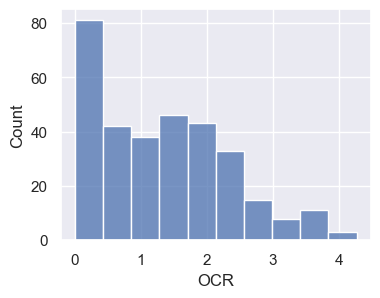

In [22]:
sns.set(rc={"figure.figsize":(4, 3)})
plot_df = su_df[su_df["OCR"] != "error"]
sns.histplot(data=plot_df, x="OCR")

<Axes: xlabel='OCR'>

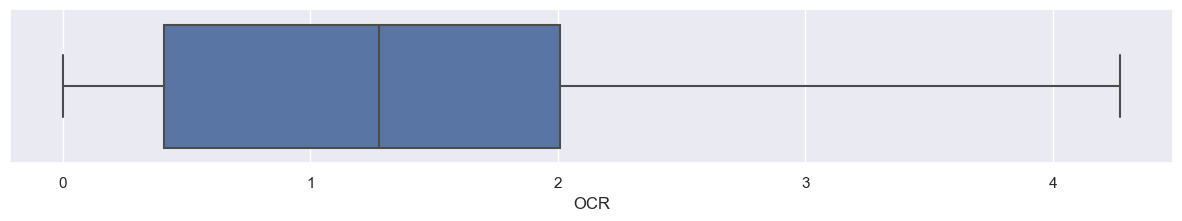

In [23]:
sns.set(rc={"figure.figsize":(15, 2)})
plot_df = su_df[(su_df["OCR"] != "error")]
sns.boxplot(data=plot_df, x="OCR")

## Linear plot Su/σ'v : OCR

Text(0.5, 1.0, "Su/σ'v : OCR")

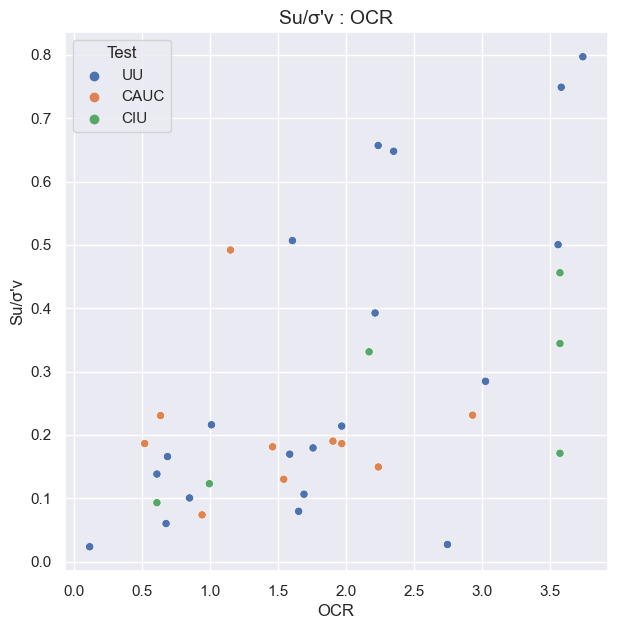

In [28]:
sns.set(rc={"figure.figsize":(7, 7)})
#plot_df = su_df[(su_df["PI"] != "error") & (su_df["Su/σ'v"] < 1) & (su_df["Test"] != "LPEN") & (su_df["Test"] != "TORV") & (su_df["Test"] != "CID")]
comp_df = su_df[(su_df["PI"] != "error") & ((su_df["Test"] == "CAUC") | (su_df["Test"] == "CIU") | (su_df["Test"] == "UU"))]
plot_df = comp_df[comp_df["OCR"] > 0].copy()
ax = sns.scatterplot(data=plot_df, x="OCR", y="Su/σ'v", hue="Test")
ax.set_title("Su/σ'v : OCR", size=14)

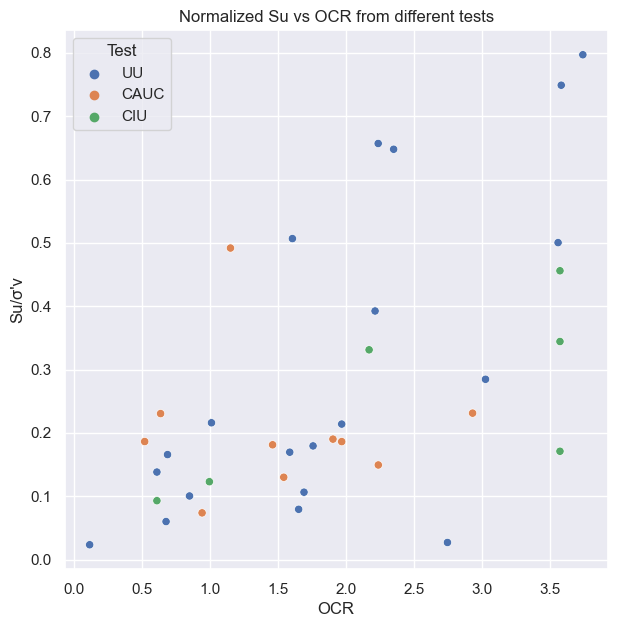

In [29]:
sns.set(rc={"figure.figsize":(7, 7)})
#plot_df = su_df[(su_df["PI"] != "error") & (su_df["Test"] != "LPEN") & (su_df["Test"] != "TORV") & (su_df["Test"] != "CID")].copy()
plot_df["OCR log"] = plot_df["OCR"].apply(lambda x: math.log(x))
plot_df["Su/σ'v log"]  = plot_df["Su/σ'v"].apply(lambda x: math.log(x))

f, ax = plt.subplots(figsize=(7, 7))
#sns.regplot(data=plot_df, x="OCR log", y="Su/σ'v log", color="pink")
ax = sns.scatterplot(data=plot_df, x="OCR", y="Su/σ'v", hue="Test")
ax.set_title("Normalized Su vs OCR from different tests")
plt.show(ax)

## Log plot Su/σ'v : OCR

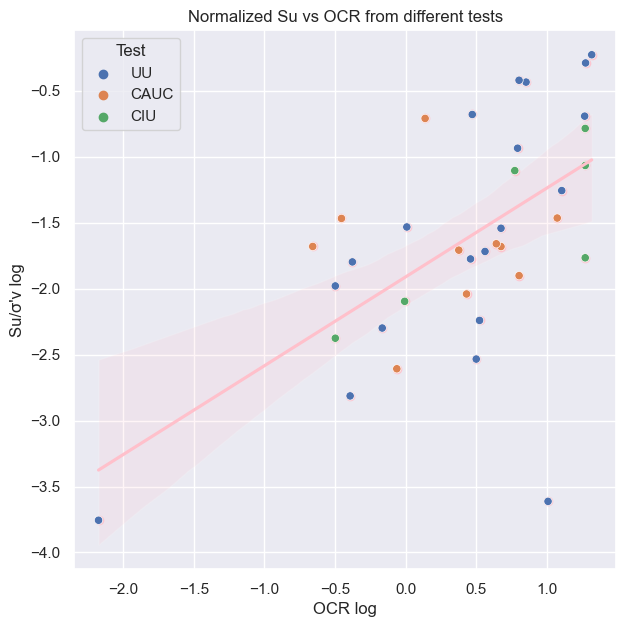

0.67 -1.91


In [30]:
sns.set(rc={"figure.figsize":(7, 7)})
#plot_df = su_df[(su_df["PI"] != "error") & (su_df["Test"] != "LPEN") & (su_df["Test"] != "TORV") & (su_df["Test"] != "CID")].copy()
plot_df["OCR log"] = plot_df["OCR"].apply(lambda x: math.log(x))
plot_df["Su/σ'v log"]  = plot_df["Su/σ'v"].apply(lambda x: math.log(x))

f, ax = plt.subplots(figsize=(7, 7))
sns.regplot(data=plot_df, x="OCR log", y="Su/σ'v log", color="pink")
ax = sns.scatterplot(data=plot_df, x="OCR log", y="Su/σ'v log", hue="Test")
ax.set_title("Normalized Su vs OCR from different tests")
plt.show(ax)
# get equation of line
slope, intercept, r, p, sterr = scipy.stats.linregress(x=ax.get_lines()[0].get_xdata(),
                                                       y=ax.get_lines()[0].get_ydata())
print(round(slope, 2), round(intercept, 2))
#print(10**(slope), 10**(intercept))

In [31]:
#plot_df.to_excel("data/shansep plot.xlsx")

## Linear regression with {OCR, PI, FC} : Su/σ'v

In [13]:
reg_df = plot_df[plot_df["OCR log"].notnull()]
X = reg_df[["OCR log", "PI", "FC"]].to_numpy()
y = reg_df["Su/σ'v log"]
reg = LinearRegression().fit(X, y)
print("R2:", reg.score(X, y))
# The coefficients
print("Coefficients: \n", reg.coef_)

R2: 0.3984329527871423
Coefficients: 
 [0.71092401 0.00207339 0.00904578]


In [146]:
plot_dict = {"CAUC" : "orange", "CAUE": "green", "CIU": "red", "UU": "blue"}
for t in plot_dict:
    reg_df = plot_df[(plot_df["OCR log"].notnull()) & (plot_df["Test"] == t)]
    X = reg_df[["OCR log", "PI", "FC"]].to_numpy()
    y = reg_df["Su/σ'v log"]
    reg = LinearRegression().fit(X, y)
    print(t, round(reg.score(X, y), 2))

CAUC 0.38
CAUE 0.24
CIU 0.75
UU 0.48


### Linear regression on individual tests
plot_dict = {"CAUC" : "orange",
             "CAUE": "green",
             "CIU": "red",
            "UU": "blue"}
for t in plot_dict:
    reg_df = plot_df[(plot_df["OCR log"].notnull()) & (plot_df["Test"] == t)]
    X = reg_df[["OCR log", "PI", "FC"]].to_numpy()
    y = reg_df["Su/σ'v log"]
    reg = LinearRegression().fit(X, y)
    print(t, round(reg.score(X, y), 2))

## Find a characteristic value for each layer with available OCR, PI and FC data

In [247]:
psd_stat = pd.DataFrame(psd_df.groupby(["PointID", "Index"]).agg({"GRAG_FINE": 
            ['count', 'max', 'min', 'mean', 'median', 'std', 'skew']}))
att_stat = pd.DataFrame(att_df.groupby(["PointID", "Index"]).agg({"LLPL_PI": 
            ['count', 'max', 'min', 'mean', 'median', 'std', 'skew']}))
ocr_df["Index"] = ocr_df.apply(lambda x: find_index(geo_df, x.PointID, x.Depth), axis=1)
ocr_stat = pd.DataFrame(ocr_df.groupby(["PointID", "Index"]).agg({"OCR": 
            ['count', 'max', 'min', 'mean']}))
comp_stat = pd.DataFrame(comp_df.groupby(["PointID", "Index"]).agg({"Su": 
            ['count', 'max', 'min', 'mean', 'median', 'std', 'skew']}))
# Find a characteristic value for each layer with available OCR, PI and FC data
pa_stat = pd.merge(psd_stat, att_stat, left_index=True, right_index=True)
pa_stat = pa_stat.rename(columns={"GRAG_FINE" : "FC", "LLPL_PI" : "PI"})
pred_df = pd.concat([psd_stat, att_stat, ocr_stat], axis=1, join="inner")
#pred_df = all_stat_df[["GRAG_FINE", "mean"], ["LLPL_PI", "mean"], ["OCR", "mean"]].copy()
pred_list = [pred_df["OCR", "mean"].to_list(), pred_df["LLPL_PI", "mean"].to_list(), pred_df["GRAG_FINE", "mean"].to_list()]
pred_df = pd.DataFrame(np.array(pred_list).T, columns=["OCR", "PI", "FC"])
pred_df["OCR log"] = pred_df.apply(lambda x: math.log(x.OCR), axis=1)
pred_df

,OCR,PI,FC,OCR log
0,4.562309,13.000000,29.550000,1.517829
1,4.665347,15.800000,57.625000,1.540162
2,3.054133,22.500000,59.250000,1.116496
3,4.125019,24.142857,89.750000,1.417071
4,1.612057,9.000000,38.500000,0.477511
5,5.202696,15.000000,34.250000,1.649177
6,6.411215,12.750000,58.420000,1.858049
7,3.891293,1.000000,83.500000,1.358741
8,3.208497,14.400000,84.100000,1.165803
9,5.157696,13.000000,58.800000,1.640490


<Axes: xlabel='FC', ylabel="Su/σ'v log">

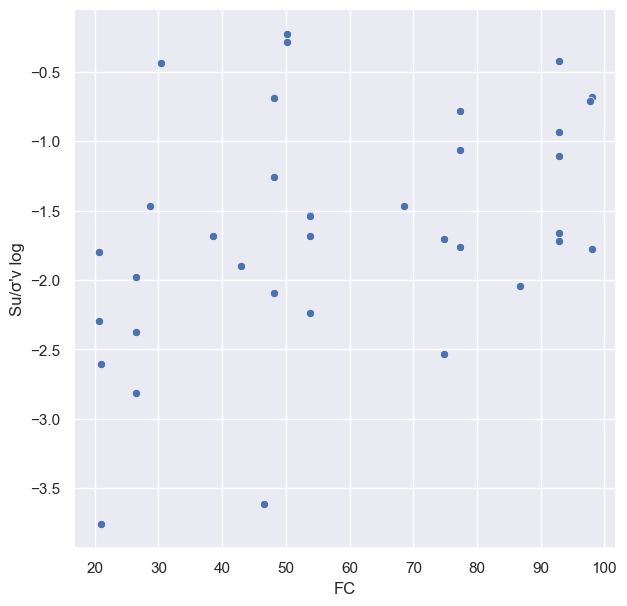

In [72]:
sns.scatterplot(data=reg_df, y="Su/σ'v log", x="FC")

In [76]:
lr = LinearRegression()
lr_scores = cross_val_score(lr, X, y, cv=5, scoring='r2')
print(f'Linear Regression R² scores: {lr_scores}')
print(f'Mean R² score: {lr_scores.mean():.2f}')

Linear Regression R² scores: [-0.27732567 -0.4251485  -0.34060766 -3.40250324  0.15089978]
Mean R² score: -0.86


In [78]:
dt = DecisionTreeRegressor()
dt_scores = cross_val_score(dt, X, y, cv=5, scoring='r2')
print(f'Decision Tree R² scores: {dt_scores}')
print(f'Mean R² score: {dt_scores.mean():.2f}')

Decision Tree R² scores: [ 0.27703876 -1.90290953 -0.00963668 -4.01548194 -0.69249033]
Mean R² score: -1.27


In [83]:
rf = RandomForestRegressor()
rf_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print(f'Random Forest R² scores: {rf_scores}')
print(f'Mean R² score: {rf_scores.mean():.2f}')

Random Forest R² scores: [ 0.13528788 -0.05591301 -0.37484346 -5.20927879  0.62014999]
Mean R² score: -0.98


In [81]:
gb = GradientBoostingRegressor()
gb_scores = cross_val_score(gb, X, y, cv=5, scoring='r2')
print(f'Gradient Boosting R² scores: {gb_scores}')
print(f'Mean R² score: {gb_scores.mean():.2f}')

Gradient Boosting R² scores: [ 0.47023608 -1.58904747 -0.14460999 -8.49626054 -0.1765687 ]
Mean R² score: -1.99


In [112]:
# knn with standard scaler
reg_df = plot_df[plot_df["OCR log"].notnull()]
#X = reg_df[["OCR log", "PI", "FC"]].to_numpy()
X = reg_df[["OCR log", "PI", "FC"]].to_numpy()
y = reg_df["Su/σ'v log"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(),
                     KNeighborsRegressor(n_neighbors=3))
pipe.fit(X_train, y_train)  # apply scaling on training data
#Pipeline(steps=[('standardscaler', StandardScaler()),
#                 ('knnregressor', KNeighborsRegressor(n_neighbors=3))])

print(pipe.score(X_test, y_test))  # apply scaling on testing data, without leaking training data.

param_grid = {'n_neighbors': range(1, 11)}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print(f'Best number of neighbors: {grid_search.best_params_}')
print(f'Best cross-validated R² score: {grid_search.best_score_:.2f}')

0.4837017862289371
Best number of neighbors: {'n_neighbors': 4}
Best cross-validated R² score: -0.14


In [63]:
reg_df = plot_df[plot_df["OCR log"].notnull()]
X = reg_df[["OCR log", "PI", "FC"]].to_numpy()
y = reg_df["Su/σ'v log"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=None)
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_train, y_train)
predictions = neigh.predict(X_test)
 
# Evaluate the model
print('Score:', neigh.score(X_test, y_test))

Score: -0.5382023510101084


In [58]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(neigh, X, y, cv=5, scoring='r2')
print(f'Cross-validated R² scores: {scores}')
print(f'Mean R² score: {scores.mean():.2f}')

from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 11)}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print(f'Best number of neighbors: {grid_search.best_params_}')
print(f'Best cross-validated R² score: {grid_search.best_score_:.2f}')

Cross-validated R² scores: [-1.60193117 -3.76186621 -0.66182102 -2.35768299  0.11812591]
Mean R² score: -1.65
Best number of neighbors: {'n_neighbors': 4}
Best cross-validated R² score: -0.14


In [237]:
# Prediction
su_pred = neigh.predict(pred_df[["OCR log", "PI", "FC"]].to_numpy())
pred_df["Su/σ'v predicted"] = su_pred
pred_df

,OCR,PI,FC,OCR log,Su/σ'v predicted
0,4.562309,13.000000,29.550000,1.517829,-1.399100
1,4.665347,15.800000,57.625000,1.540162,-0.686040
2,3.054133,22.500000,59.250000,1.116496,-1.821269
3,4.125019,24.142857,89.750000,1.417071,-1.081086
4,1.612057,9.000000,38.500000,0.477511,-2.398080
5,5.202696,15.000000,34.250000,1.649177,-1.192982
6,6.411215,12.750000,58.420000,1.858049,-0.661205
7,3.891293,1.000000,83.500000,1.358741,-1.205933
8,3.208497,14.400000,84.100000,1.165803,-1.624317
9,5.157696,13.000000,58.800000,1.640490,-0.661205


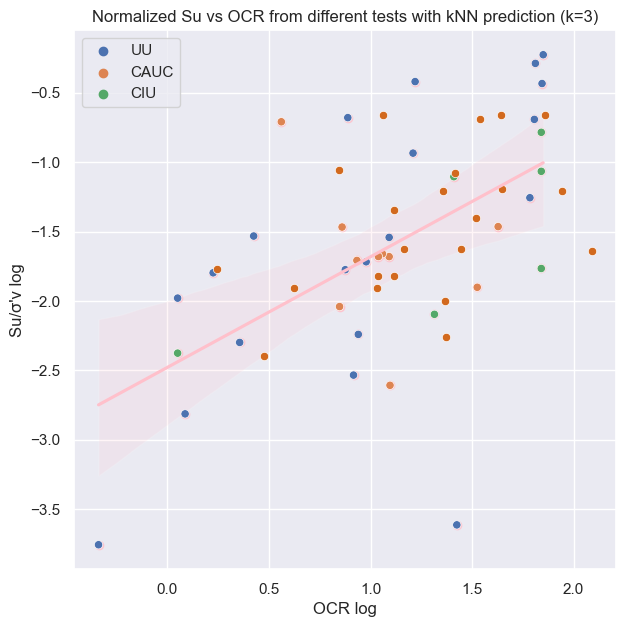

In [239]:
sns.set(rc={"figure.figsize":(7, 7)})
#plot_df = su_df[(su_df["PI"] != "error") & (su_df["Test"] != "LPEN") & (su_df["Test"] != "TORV") & (su_df["Test"] != "CID")].copy()
plot_df["OCR log"] = plot_df["OCR"].apply(lambda x: math.log(x))
plot_df["Su/σ'v log"]  = plot_df["Su/σ'v"].apply(lambda x: math.log(x))

f, ax = plt.subplots(figsize=(7, 7))
sns.regplot(data=plot_df, x="OCR log", y="Su/σ'v log", color="pink")
ax = sns.scatterplot(data=plot_df, x="OCR log", y="Su/σ'v log", hue="Test")
ax = sns.scatterplot(data=pred_df, x="OCR log", y="Su/σ'v predicted", color="chocolate")
ax.set_title("Normalized Su vs OCR from different tests with kNN prediction (k=3)")
plt.show(ax)

In [248]:
comp_stat

Su                                                   \
                    count     max     min        mean   median         std   
PointID       Index                                                          
544WTG23-BH01 4         2  203.30   73.00  138.150000  138.150   92.136014   
              6         7  207.00   76.33  156.047143  174.000   50.579563   
              8         2  275.20  104.70  189.950000  189.950  120.561706   
544WTG23-BH02 3         2  154.70  145.30  150.000000  150.000    6.646804   
              5         6  447.20   87.00  218.533333  188.000  131.620829   
              6         1  188.00  188.00  188.000000  188.000         NaN   
              9         1  376.00  376.00  376.000000  376.000         NaN   
544WTG23-BH04 4         5  211.80   75.00  151.660000  151.000   56.572325   
              6         2  227.00  171.00  199.000000  199.000   39.597980   
              9         3  392.20   35.30  263.666667  363.500  198.291259   
544WTG23-BH05 2         2   40.00   37.16   38.580000   38.580    2.008183   
              9         7  204.00   11.86   85.370000   62.730   77.239188   
              13        3  256.00  115.70  172.066667  144.500   74.101035   
544WTG23-BH06 2         1   75.61   75.61   75.610000   75.610         NaN   
              3         3  183.90   61.53  138.476667  170.000   66.999214   
              5         2  219.20  132.80  176.000000  176.000   61.094026   
              6         1  449.70  449.70  449.700000  449.700         NaN   
              9         1   99.43   99.43   99.430000   99.430         NaN   
544WTG23-BH07 7         1  134.00  134.00  134.000000  134.000         NaN   
544WTG23-BH08 7         1  231.00  231.00  231.000000  231.000         NaN   
              8         2  254.00  209.00  231.500000  231.500   31.819805   
              9         3  307.00  216.00  256.333333  246.000   46.371687   
544WTG23-BH09 2         2   36.18   29.83   33.005000   33.005    4.490128   
544WTG23-BH10 8         2  110.00   34.46   72.230000   72.230   53.414846   
              9         3  263.10  114.30  184.800000  177.000   74.706024   
              12        2  386.00  296.20  341.100000  341.100   63.498189   
544WTG23-BH11 3         3   96.07   68.00   83.056667   85.100   14.146117   
              5         1   14.04   14.04   14.040000   14.040         NaN   
              6         4  392.20  106.00  247.375000  245.650  117.554197   
              8         1  249.00  249.00  249.000000  249.000         NaN   
              9         2  379.30  196.90  288.100000  288.100  128.976277   
              10        3  422.00   35.14  216.713333  193.000  194.517111   

                               
                         skew  
PointID       Index            
544WTG23-BH01 4           NaN  
              6     -0.975633  
              8           NaN  
544WTG23-BH02 3           NaN  
              5      1.133625  
              6           NaN  
              9           NaN  
544WTG23-BH04 4     -0.345871  
              6           NaN  
              9     -1.691320  
544WTG23-BH05 2           NaN  
              9      0.885196  
              13     1.442384  
544WTG23-BH06 2           NaN  
              3     -1.648558  
              5           NaN  
              6           NaN  
              9           NaN  
544WTG23-BH07 7           NaN  
544WTG23-BH08 7           NaN  
              8           NaN  
              9      0.952973  
544WTG23-BH09 2           NaN  
544WTG23-BH10 8           NaN  
              9      0.464720  
              12          NaN  
544WTG23-BH11 3     -0.636440  
              5           NaN  
              6      0.085939  
              8           NaN  
              9           NaN  
              10     0.540436

In [ ]:
plot_df = cpt_df
xmin, xmax = 0, 1000
############################
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(2, 5)
fig.suptitle(f'Distribution of {parameter} by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 30)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 10)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="tomato", s=10, label="Nkt=10")
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 20)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="deepskyblue", s=10, label="Nkt=20")
            ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Test", marker="X", alpha=1, ax=axes[row, col], s=80,
                                 palette=dict(CU="#9b59b6", UU="#076928", LPEN="#eb4034", TORV="#a69b08"))
            # Plot geology
            bh_geo = geo_df[geo_df["PointID"] == borehole_list[bh]]
            for z, geol in zip(bh_geo["Depth"].to_list(), bh_geo["Soil type"].to_list()):
                if geol == "01-CLAY" or geol == "02-SILT":
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=1, color="firebrick", linestyle='dashed')
                else:
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=0.3, color="navy", linestyle='dashed')
            ax.set_title(borehole_list[bh], size=16)
            ax.set_ylabel("Depth (m)")
            ax.set_xlabel("Su (kPa)")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            ax.legend()
            bh += 1

## Other plots

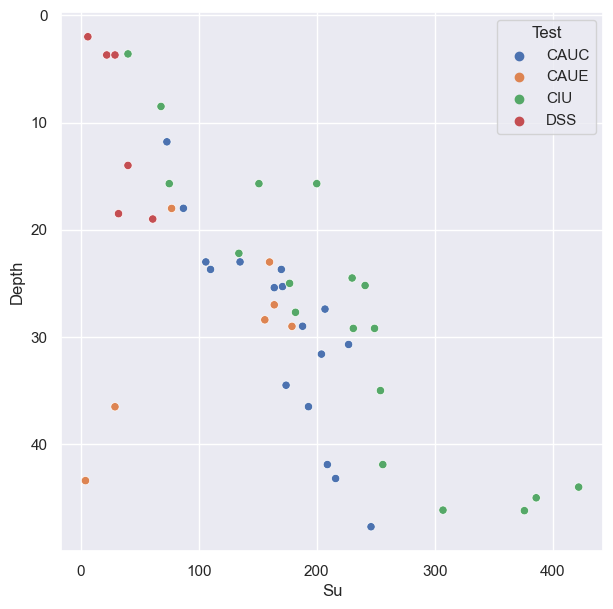

In [81]:
plot_df = su_df[(su_df["Test"] != "UU") & (su_df["Test"] != "LPEN") & (su_df["Test"] != "TORV") & (su_df["Test"] != "CID")]
ax = sns.scatterplot(data=plot_df, x="Su", y="Depth", hue="Test")
ax.invert_yaxis()

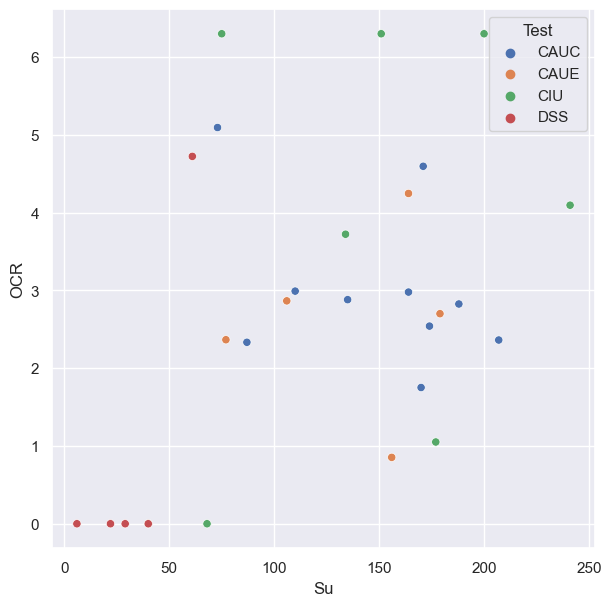

In [115]:
plot_df = su_df[(su_df["Test"] != "UU") & (su_df["Test"] != "LPEN") & (su_df["Test"] != "TORV") & (su_df["Test"] != "CID")]
ax = sns.scatterplot(data=plot_df, x="Su", y="OCR", hue="Test")

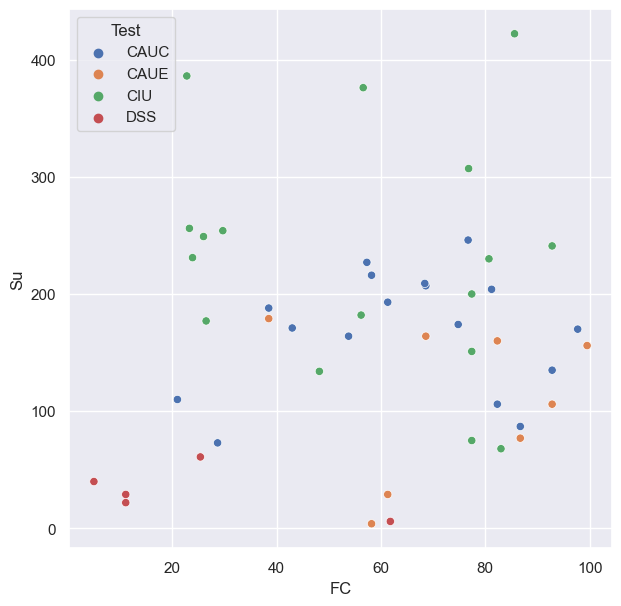

In [220]:
plot_df = plot_df[plot_df["Test"] != "UU"]
ax = sns.scatterplot(data=plot_df, y="Su", x="FC", hue="Test")

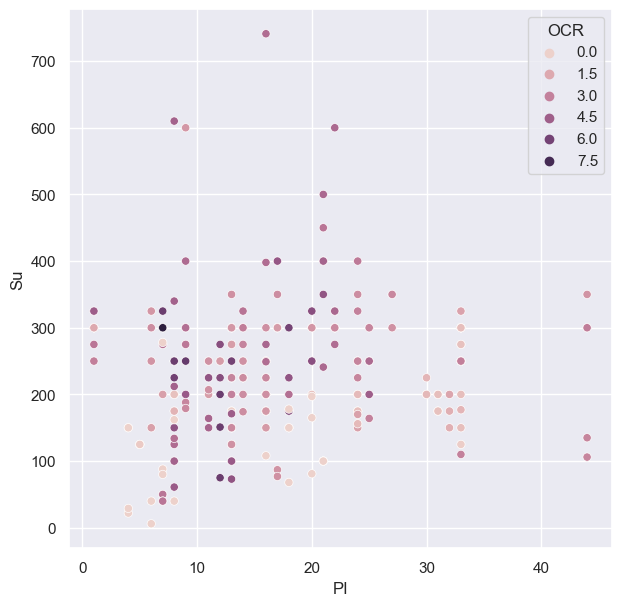

In [92]:
plot_df = su_df[su_df["Test"] != "UU"]
ax = sns.scatterplot(data=plot_df, y="Su", x="PI", hue="OCR")

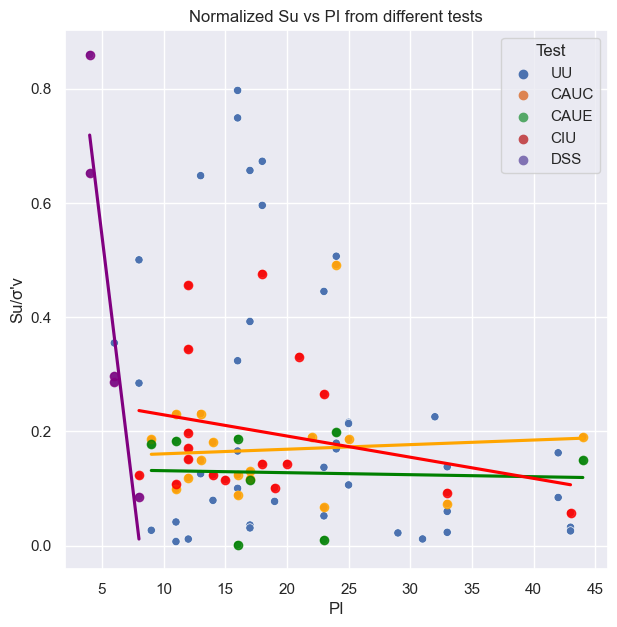

In [196]:
sns.set(rc={"figure.figsize":(7, 7)})
plot_df = su_df[(su_df["PI"] != "error") & (su_df["Su/σ'v"] < 1) & (su_df["Test"] != "LPEN") & (su_df["Test"] != "TORV") & (su_df["Test"] != "CID")]
ax = sns.scatterplot(data=plot_df, x="PI", y="Su/σ'v", hue="Test")
plot_dict = {"CAUC" : "orange",
             "CAUE": "green",
             "CIU": "red",
             "DSS": "purple"}
for t in plot_dict:
    test_df = plot_df[(plot_df["Test"] == t)]
    ax = sns.regplot(x=test_df["PI"].astype('float'), y=test_df["Su/σ'v"].astype('float'), color=plot_dict[t], ci=None)
ax.set_title("Normalized Su vs PI from different tests")
plt.show()

In [193]:
su_df[su_df["Test"] == "DSS"]

,raw PointID,Depth,Su,Test,PointID,Index,σv (kPa),σ'v (kPa),Su/σ'v,PI,PI Δ,PI Δ index,FC,FC Δ,FC Δ index
602,544WTG23-BH01,3.7,22.0,DSS,544WTG23-BH01,2,486.501400,33.741400,0.652018,4.0,6.0,1.0,11.1,0.0,0.0
603,544WTG23-BH01,3.7,29.0,DSS,544WTG23-BH01,2,486.501400,33.741400,0.859478,4.0,6.0,1.0,11.1,0.0,0.0
604,544WTG23-BH03a,18.5,32.0,DSS,544WTG23-BH03,5,801.335241,203.535241,0.157221,error,error,error,5.4,11.5,-3.0
605,544WTG23-BH05,2.0,6.0,DSS,544WTG23-BH05,2,456.288000,20.188000,0.297206,6.0,0.0,0.0,61.8,0.0,0.0
606,544WTG23-BH06,14.0,40.0,DSS,544WTG23-BH06,2,693.592822,139.892822,0.285933,6.0,8.5,1.0,5.0,0.0,0.0
607,544WTG23-BH07,19.0,61.0,DSS,544WTG23-BH07,6,1317.480173,714.780173,0.085341,8.0,3.4,1.0,25.4,0.0,0.0


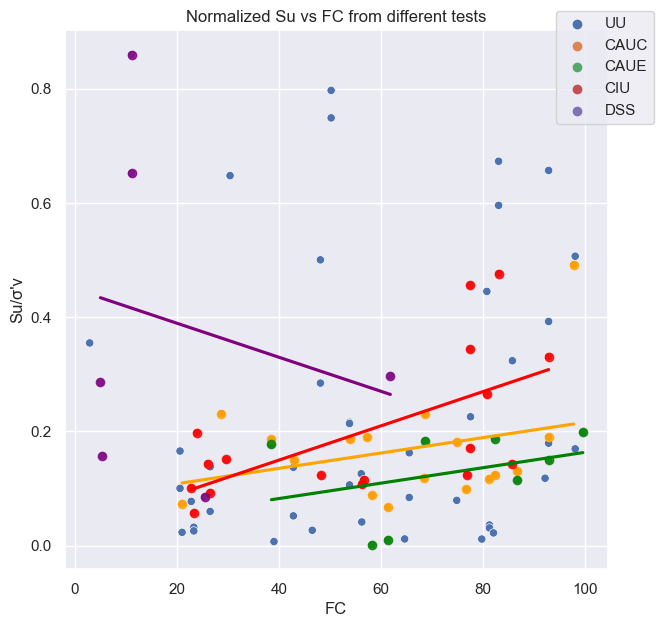

In [195]:
sns.set(rc={"figure.figsize":(7, 7)})
plot_df = su_df[(su_df["FC"] != "error") & (su_df["Su/σ'v"] < 1) & (su_df["Test"] != "LPEN") & (su_df["Test"] != "TORV") & (su_df["Test"] != "CID")]
ax = sns.scatterplot(data=plot_df, x="FC", y="Su/σ'v", hue="Test")
plot_dict = {"CAUC" : "orange",
             "CAUE": "green",
             "CIU": "red",
             "DSS": "purple"}
for t in plot_dict:
    test_df = plot_df[(plot_df["Test"] == t)]
    ax = sns.regplot(x=test_df["FC"].astype('float'), y=test_df["Su/σ'v"].astype('float'), color=plot_dict[t], ci=None)
ax.set_title("Normalized Su vs FC from different tests")
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()